In [13]:
import os
import numpy as np
import pandas as pd

import pickle
from typing import Any, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

import torchvision
import torchmetrics


import pytorch_lightning as pl
from pytorch_lightning.utilities.types import STEP_OUTPUT

from transformers import T5Tokenizer, T5ForConditionalGeneration

from tqdm import tqdm

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import clip
from ultralytics import YOLO

/home/matea/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
%%bash
pip install -q gdown
pip install -q torch
pip install -q pytorch-lightning
pip install -q ultralytics
pip install -q ftfy regex tqdm
pip install -q git+https://github.com/openai/CLIP.git
pip install -q transformers==4.29
pip install -q sentencepiece==0.1.97

In [ ]:
%%bash
unzip /content/refcocog.tar.zip
rm /content/refcocog.tar.zip

In [1]:
from torch.utils.data import Dataset

import json

class RefCOCOg(Dataset):
    """
    Args:
        dataset: a list of dictionaries containing:
        {
            'file_name': # path of the image, images will be loaded on the fly
            'caption': # referring caption
            'ann_id': # annotation ID (one per caption), taken from 'file_name'
            'bbox': # coordinates (xmin, ymin, xmax, ymax) of the bounding box
        }
    """
    def __init__(self, refs, annotations, split="train"):

        self.dataset = [{"file_name": os.path.join("./refcocog/images/", f'{"_".join(elem["file_name"].split("_")[:3])}.jpg'),
                            "caption": elem["sentences"][0]["raw"],
                            "ann_id": int(elem["file_name"].split("_")[3][:-4]),
                            "bbox": annotations[int(elem["file_name"].split("_")[3][:-4])]}
                        for elem in [d for d in refs if d["split"]==split]]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

    def __call__(self, idx):
        print(json.dumps(self.dataset[idx], indent=4))

In [3]:
# Load refs and annotations
import pickle

with open("./refcocog/annotations/refs(umd).p", "rb") as fp:
  refs = pickle.load(fp)

# 'annotations' will be a dict object mapping the 'annotation_id' to the 'bbox' to make search faster
with open("./refcocog/annotations/instances.json", "rb") as fp:
  data = json.load(fp)
  annotations = dict(sorted({ann["id"]: ann["bbox"] for ann in data["annotations"]}.items()))

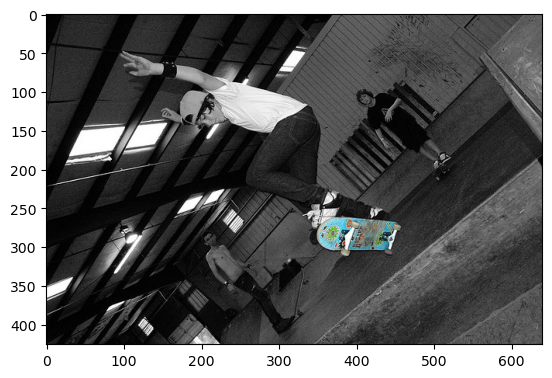

In [9]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import os

from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image, ImageDraw

def pad_image(image):
    """
    Performs bottom-right padding of the original image to 640x640 (max size of images in the dataset).
    Bottom-right padding prevents corruption of bounding boxes.

    ### Arguments
    image: a PIL.Image to transform
    """
    original_width, original_height = image.size
    padded_width, padded_height = 640, 640

    pad_width = padded_width - original_width
    pad_height = padded_height - original_height

    padded_image = Image.new(image.mode, (padded_width, padded_height), (0, 0, 0))
    padded_image.paste(image, (0, 0))

    return padded_image

def collate_fn(batch):
    images = []
    for sample in batch:
        image = Image.open(sample["file_name"]).convert("RGB")
        image = pad_image(image=image)
        images.append(transform(image))
    images = torch.stack(images, dim=0)

    data = {}
    for key in batch[0].keys():
        if key != "file_name":
            data[key] = [sample[key] for sample in batch]
    return images, data

transform = transforms.Compose([
    transforms.ToTensor(),
])

# create dataset and dataloader
dataset = RefCOCOg(refs, annotations, split="train")
plt.imshow(Image.open(dataset[2]["file_name"]))
dataloader = DataLoader(dataset, batch_size=1, collate_fn=collate_fn)


### Usage:

# for d in dataloader:

#     img = np.array(d[0][0].cpu().numpy().transpose(1, 2, 0)*255, dtype=np.uint8)
#     bbox = d[1]["bbox"][0]
#     img = Image.fromarray(img)
#     draw = ImageDraw.Draw(img)
#     draw.rectangle(((bbox[0], bbox[1]), (bbox[2]+bbox[0], bbox[3]+bbox[1])), width=3)

#     plt.imshow(img)
#     plt.show()
#     break

In [11]:
import torch
import clip
from PIL import Image, ImageDraw
import cv2
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
class YoloClip():
    def __init__(self):

        self.yolo = torch.hub.load('ultralytics/yolov5', 'yolov5l6', pretrained=True)
        self.clip_model, self.clip_preprocess = clip.load("ViT-B/32", device=device)

    def infer_bboxes(self, image_path):
        results = self.yolo(image_path)
        bboxes = results.xyxy[0].cpu().numpy()
        return bboxes

    def encode_image(self, image):
        # Load and preprocess the image using CLIP preprocess function
        image = self.clip_preprocess(image).unsqueeze(0).to(self.device)

        # Encode the image using the CLIP model
        with torch.no_grad():
            image_features = self.clip_model.encode_image(image)

        return image_features

    def encode_text(self, text):
        # Encode the text using the CLIP model
        text = clip.tokenize(text).to(self.device)
        with torch.no_grad():
            text_features = self.clip_model.encode_text(text)

        return text_features

    def calculate_best_bbox(self, image_path, caption, device):
        text = clip.tokenize(caption).to(device)
        best_score = 0
        best_bbox = None

        for bbox in self.infer_bboxes(image_path):
            temp = cv2.imread(image_path)
            image = np.zeros((temp.shape[0], temp.shape[1], temp.shape[2]), dtype=np.uint8)
            image[int(bbox['ymin']):int(bbox['ymax']), int(bbox['xmin']):int(bbox['xmax'])] = temp[int(bbox['ymin']):int(bbox['ymax']), int(bbox['xmin']):int(bbox['xmax'])]
            image = Image.fromarray(image).to(device)

            with torch.no_grad():
                logits_per_image, logits_per_text = self.clip_model(image, text)
                matching_score = logits_per_text.cpu().numpy()[0]

            if matching_score > best_score:
                best_score = matching_score
                best_bbox = bbox

        return best_score, best_bbox

In [14]:
# Constants and models

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# YOLO
#model_yolo = YOLO("yolov8x.pt")

# CLIP
clip_model, clip_preprocess = clip.load("RN50", device=device)

100%|██████████| 131M/131M [00:12<00:00, 11.2MB/s] 
100%|███████████████████████████████████████| 338M/338M [00:44<00:00, 7.98MiB/s]
